In [1]:
import dns
import numpy as np
from pathlib import Path
from scipy import optimize as opt
from tqdm.auto import tqdm
from matplotlib import pyplot as plt

In [2]:
Ry = True
dt = 0.1
statesdir = Path("/home/gokhan/projects/dnsbox/re180Lx24Lz8")
savedir = Path("/home/gokhan/projects/dnsbox/re180Lx24Lz8/slice")
states = sorted(list(statesdir.glob("state.*")))[6000:9000]

In [3]:
state_, header_ = dns.readState(states[0])
forcing, nx, ny, nz, Lx, Lz, Re, tilt_angle, dt, itime, time = header_
ny_half = ny // 2

In [4]:
if Ry and ny_half % 2 != 0:
    exit("Ry but ny_half is not even.")

In [5]:
projections_xu = np.zeros((len(states), ny_half), dtype=np.complex128)
projections_zu = np.zeros((len(states), ny_half), dtype=np.complex128)

projections_xv = np.zeros((len(states), ny_half-1), dtype=np.complex128)
projections_zv = np.zeros((len(states), ny_half-1), dtype=np.complex128)

projections_xw = np.zeros((len(states), ny_half), dtype=np.complex128)
projections_zw = np.zeros((len(states), ny_half), dtype=np.complex128)

In [7]:
times = []
for istate in range(len(states)):
    if istate % 100 == 0:
        print(istate, len(states))
    state, header = dns.readState(states[istate])
    forcing, nx, ny, nz, Lx, Lz, Re, tilt_angle, dt_, itime, time = header
    times.append(time)
    if Ry:
        # u component, only even modes
        # x template
        projections_xu[istate, :] = (state[1,:,0,0] + np.conj(state[-1,:,0,0]))/2
        # z template
        projections_zu[istate, :] = (state[0,:,1,0] + np.conj(state[0,:,-1,0]))/2
        
        # v component, only odd modes
        # x template
        projections_xv[istate, :] = -1j*(state[1,1:,0,1] - np.conj(state[-1,1:,0,1]))/2
        # z template
        projections_zv[istate, :] = -1j*(state[0,1:,1,1] - np.conj(state[0,1:,-1,1]))/2
        
        # w component, only even modes
        # x template
        projections_xw[istate, :] = (state[1,:,0,2] + np.conj(state[-1,:,0,2]))/2
        # z template
        projections_zw[istate, :] = (state[0,:,1,2] + np.conj(state[0,:,-1,2]))/2

0 3000
100 3000
200 3000
300 3000
400 3000
500 3000
600 3000
700 3000
800 3000
900 3000
1000 3000
1100 3000
1200 3000
1300 3000
1400 3000
1500 3000
1600 3000
1700 3000
1800 3000
1900 3000
2000 3000
2100 3000
2200 3000
2300 3000
2400 3000
2500 3000
2600 3000
2700 3000
2800 3000
2900 3000


In [16]:
projections_x = np.zeros((len(states), 3*ny_half-1), dtype=np.complex128)
projections_z = np.zeros((len(states), 3*ny_half-1), dtype=np.complex128)

projections_x[:,:ny_half] = projections_xu[:,:]
projections_x[:,ny_half:2*ny_half-1] = projections_xv[:,:]
projections_x[:,2*ny_half-1:] = projections_xw[:,:]

projections_z[:,:ny_half] = projections_zu[:,:]
projections_z[:,ny_half:2*ny_half-1] = projections_zv[:,:]
projections_z[:,2*ny_half-1:] = projections_zw[:,:]

In [25]:
def find_shift(projection):
    shift = (np.arctan2(projection.imag, projection.real) / (2 * np.pi)) % 1
    return shift

def find_dphases(projections):
    shifts = find_shift(projections)
    phases = np.unwrap(shifts * 2 * np.pi)
    dphases = (phases[1:] - phases[:-1]) / dt
    return dphases

def constraint_unit_template(coeffs):
    return np.sqrt(np.sum(coeffs**2))

def maximize_average(coeffs, projs):
    res = projs @ coeffs
    abs_res = np.abs(res)
    return -np.sqrt(np.average(abs_res**2))

In [44]:
def optimal_template(projections,str_projections,verbose=1,maxiter=1000):
    
    tag = f"{str_projections}"
    print(tag)
    
    nstates, ncoeffs = projections.shape
    x0 = np.ones((ncoeffs))/np.sqrt(ncoeffs)
    
    constraints = opt.NonlinearConstraint(constraint_unit_template,1,1)
    
    # run the optimization
    opts = opt.minimize(maximize_average,x0,args=(projections,),method="trust-constr",
                        constraints=constraints,
                        options={"verbose": verbose, "maxiter": maxiter})
    
    coeffs = opts.x
    
    # save coefficients
    np.savetxt(savedir / f"coeffs_{tag}.gp", coeffs)
    
    # save template
    template = np.zeros((nx, ny_half, nz, 3), dtype=np.complex128)
    if Ry:
        if str_projections == "x":
            template[1,:,0,0] = coeffs[:ny_half] / 4
            template[-1,:,0,0] = coeffs[:ny_half] / 4

            template[1,1:,0,1] = -1j*coeffs[ny_half:2*ny_half-1] / 4
            template[-1,1:,0,1] = -1j*coeffs[ny_half:2*ny_half-1] / 4

            template[1,:,0,2] = coeffs[2*ny_half-1:] / 4
            template[-1,:,0,2] = coeffs[2*ny_half-1:] / 4

        elif str_projections == "z":
            template[0,:,1,0] = coeffs[:ny_half] / 4
            template[0,:,-1,0] = coeffs[:ny_half] / 4

            template[0,1:,1,1] = -1j*coeffs[ny_half:2*ny_half-1] / 4
            template[0,1:,-1,1] = -1j*coeffs[ny_half:2*ny_half-1] / 4

            template[0,:,1,2] = coeffs[2*ny_half-1:] / 4
            template[0,:,-1,2] = coeffs[2*ny_half-1:]/ 4
    else:
        exit("Not yet implemented.")
    
            
    dns.writeState_nocompact(template,forcing=forcing,Lx=Lx,Lz=Lz,Re=Re,tilt_angle=tilt_angle,dt=dt,
                   outFile = savedir / f"u_{str_projections}p.000000")

    projections_opt = np.einsum("ij,j",projections,coeffs,dtype=np.complex128)
    abs_projections_opt = np.abs(projections_opt)
    shifts = find_shift(projections_opt)
    phases = np.unwrap(shifts * 2 * np.pi)
    dphases = (phases[1:] - phases[:-1]) / dt

    fig, ax = plt.subplots()
    ax.plot(times, np.abs(projections_opt))
    ax.set_xlabel("$t$")
    ax.set_ylabel(f"$|p_{str_projections}|$")
    ax.set_xlim(left=times[0], right=times[-1])
    fig.savefig(savedir / f"p{tag}.png", bbox_inches="tight")

    # Plot phases
    fig, ax = plt.subplots()
    ax.plot(times, phases)
    ax.set_xlabel("$t$")
    ax.set_ylabel(f"$\\phi_{str_projections}$")
    ax.set_xlim(left=times[0], right=times[-1])
    fig.savefig(savedir / f"phase_{tag}.png", bbox_inches="tight")

    # Plot phase derivatives
    np.savetxt(savedir / f"dphases_{str_projections}.gp", dphases)
    fig, ax = plt.subplots()
    ax.plot(times[:-1], dphases)
    ax.set_xlabel("$t$")
    ax.set_ylabel(f"$\\dot{{\\phi_{str_projections}}}$")
    ax.set_xlim(left=times[0], right=times[-2])
    ax.set_xlim(600,900)
    fig.savefig(savedir / f"dphase_{tag}.png", bbox_inches="tight")
    
    plt.show()

x
`gtol` termination condition is satisfied.
Number of iterations: 139, function evaluations: 5160, CG iterations: 259, optimality: 9.99e-09, constraint violation: 1.11e-16, execution time:  0.6 s.


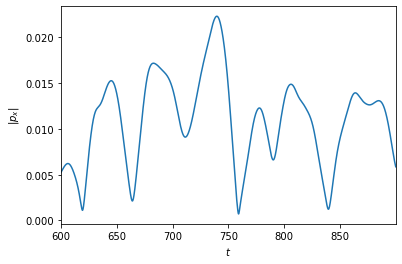

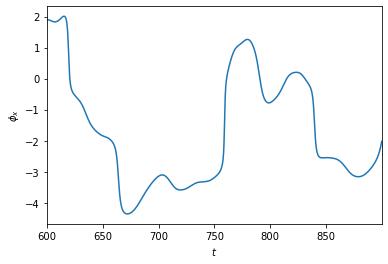

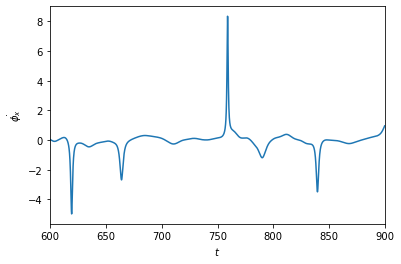

z
`gtol` termination condition is satisfied.
Number of iterations: 24, function evaluations: 1032, CG iterations: 41, optimality: 8.97e-09, constraint violation: 0.00e+00, execution time: 0.11 s.


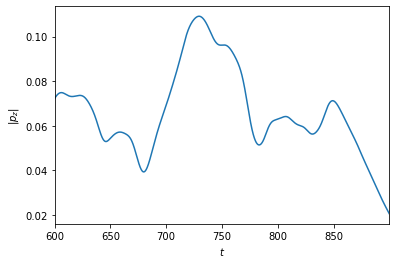

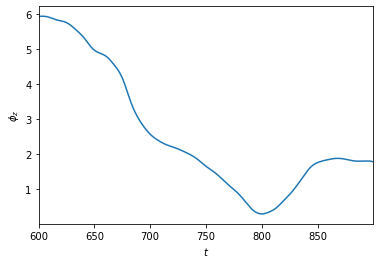

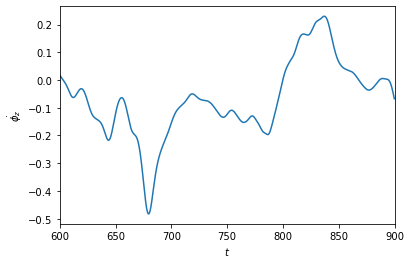

In [45]:
optimal_template(np.conj(projections_x),"x")
optimal_template(np.conj(projections_z),"z")

In [46]:
phases_dns = np.loadtxt("/home/gokhan/projects/dnsbox/re180Lx24Lz8/slice/phases.gp")
dphases_x_ = np.loadtxt("/home/gokhan/projects/dnsbox/re180Lx24Lz8/slice/dphases_x.gp")
dphases_z_ = np.loadtxt("/home/gokhan/projects/dnsbox/re180Lx24Lz8/slice/dphases_z.gp")

Text(0, 0.5, '$\\dot{\\phi_z}$')

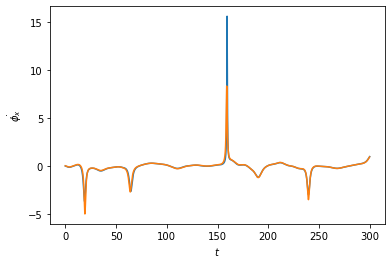

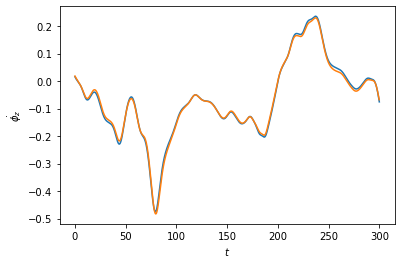

In [48]:
fig, ax = plt.subplots()
ax.plot(phases_dns[:-1,1], (np.unwrap(phases_dns[1:,2]) - np.unwrap(phases_dns[:-1,2]))/dt)
ax.plot(phases_dns[:-2,1], dphases_x_)
ax.set_xlabel("$t$")
ax.set_ylabel(f"$\\dot{{\\phi_x}}$")

fig, ax = plt.subplots()
ax.plot(phases_dns[:-1,1], (np.unwrap(phases_dns[1:,3]) - np.unwrap(phases_dns[:-1,3]))/dt)
ax.plot(phases_dns[:-2,1], dphases_z_)
ax.set_xlabel("$t$")
ax.set_ylabel(f"$\\dot{{\\phi_z}}$")